90分対策  
F12を開いて以下のスクリプトをコンソールで実行  
function KeepClicking(){
console.log("Clicking");
document.querySelector("colab-connect-button").click()
}
setInterval(KeepClicking,600000)

  
10分ごとに接続

In [ ]:
# MNISTのロードと表示のための関数です。後で使うので読み込んでおいて下さい。
from tensorflow.keras.datasets import mnist
from tensorflow.keras.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def load_mnist(dim=3, data='mnist'):
    img_rows, img_cols = 28, 28
    
    if data == 'mnist':
        (x_train, y_train), (x_test, y_test) = mnist.load_data()
    else:
        (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
    
    if dim == 3:
        x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
        x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    else:
        x_train = x_train.reshape(x_train.shape[0], img_rows*img_cols)
        x_test = x_test.reshape(x_test.shape[0], img_rows*img_cols)
        
    x_train = x_train.astype('float32') / 255
    x_test = x_test.astype('float32') / 255
    y_train = np.eye(10)[y_train]
    y_test = np.eye(10)[y_test]
    
    return  x_train, x_test, y_train, y_test

def plot_mnist(n_ex=10,dim=(2,5), figsize=(8,4)):
    noise = np.random.uniform(0,1,size=[n_ex,100])
    generated_images = generator.predict(noise)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0],dim[1],i+1)
        img = generated_images[i,:,:, 0]
        plt.imshow(img, cmap='binary')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
from tensorflow.keras.layers import Input, Reshape, Dense, Flatten, Activation, Conv2D, UpSampling2D, BatchNormalization
from tensorflow.keras.models import Model

def Generator():
    nch = 200
    model_input = Input(shape=[100])
    x = Dense(nch*14*14, kernel_initializer='glorot_normal')(model_input) # 100 -> 200*14*14
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Reshape( [14, 14, nch] )(x) # 200*14*14 -> 14x14x200 (width)x(height)x(channel)
    x = UpSampling2D(size=(2, 2))(x) # 14x14x200 -> 28x28x200
    x = Conv2D(int(nch/2), (3, 3), padding='same', kernel_initializer='glorot_uniform')(x) # 28x28x200 -> 28x28x100
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(int(nch/4), (3, 3), padding='same', kernel_initializer='glorot_uniform')(x) # 28x28x100 -> 28x28x50
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(1, (1, 1), padding='same', kernel_initializer='glorot_uniform')(x) # 28x28x50 -> 28x28x1
    model_output = Activation('sigmoid')(x)
    model = Model(model_input, model_output)
    # model.summary()
    
    return model

In [ ]:
from tensorflow.keras.layers import Input, Reshape, Dense, Dropout, Flatten, LeakyReLU, Conv2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

def Discriminator(shape, dropout_rate=0.25, opt=Adam(lr=1e-4)):
    model_input = Input(shape=shape) # 28x28x1
    x = Conv2D(256, (5, 5), padding = 'same', kernel_initializer='glorot_uniform', strides=(2, 2))(model_input) # 28x28x1 -> 14x14x256
    x = LeakyReLU(0.2)(x)
    x = Dropout(dropout_rate)(x)
    x = Conv2D(512, (5, 5), padding = 'same', kernel_initializer='glorot_uniform', strides=(2, 2))(x) # 14x14x256 -> 7x7x512
    x = LeakyReLU(0.2)(x)
    x = Dropout(dropout_rate)(x)
    x = Flatten()(x) # 7x7x512 -> 7*7*512
    x = Dense(256)(x) # 7*7*512 -> 256
    x = LeakyReLU(0.2)(x)
    x = Dropout(dropout_rate)(x)
    model_output = Dense(2,activation='softmax')(x) # 256 -> 2
    model = Model(model_input, model_output)
    model.compile(loss='categorical_crossentropy', optimizer=opt)
    # model.summary()
    
    return model

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

def combined_network(generator, discriminator, opt=Adam(lr=1e-3)):
    gan_input = Input(shape=[100])
    x = generator(gan_input)
    gan_output = discriminator(x)
    model = Model(gan_input, gan_output)
    model.compile(loss='categorical_crossentropy', optimizer=opt)
    # model.summary()
    
    return model

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val

In [ ]:
from tqdm import tqdm

def train(step=3000, BATCH_SIZE=128):
    for e in tqdm(range(step)):
        # 1. バッチの学習で利用する画像の選択 
        # バッチサイズの分だけランダムに画像を選択
        image_batch = X_train[np.random.randint(0,X_train.shape[0],size=BATCH_SIZE),:,:,:]
        
        # バッチサイズの分だけランダムにノイズを生成し、generatorにより画像を生成
        noise_gen = np.random.uniform(0,1,size=[BATCH_SIZE,100])
        generated_images = generator.predict(noise_gen)
        
        # 2. Discriminatorの学習をonに切り替える
        # Discriminatorが学習するように変更
        make_trainable(discriminator,True)
        
        # 3. Generatorによる生成画像を用いてDiscriminatorの学習
        # X = (バッチサイズ分のデータセットの画像, バッチサイズ分の生成画像)
        X = np.concatenate((image_batch, generated_images))
        
        # y = (バッチサイズ分のTrue(本物), バッチサイズ分のFalse(偽物))
        y = np.zeros([2*BATCH_SIZE,2])
        y[:BATCH_SIZE,1] = 1
        y[BATCH_SIZE:,0] = 1      
        
        # Discriminatorのtrain
        discriminator.train_on_batch(X,y)
        
        # 4. Discriminatorの学習をoffに切り替える
        # Discriminatorが学習しないように変更
        make_trainable(discriminator,False)
    
        # 5. Generatorの学習
        # バッチサイズの分だけランダムにノイズを生成
        noise_gen = np.random.uniform(0,1,size=[BATCH_SIZE,100])
        
        # y = (バッチサイズ分のTrue(本物))
        # 実際には生成した画像なのでDiscriminatorとしては偽物と判断すべきだが、Genaratorの学習なので生成した画像を本物と判断するように学習させる
        y2 = np.zeros([BATCH_SIZE,2])
        y2[:,1] = 1
        
        # Generatorのtrain
        GAN.train_on_batch(noise_gen, y2 )

In [ ]:
# データのロード
X_train, _,_,_ = load_mnist()
# それぞれのネットワークのインスタンスを生成
generator = Generator()
discriminator = Discriminator(X_train.shape[1:])
make_trainable(discriminator, False)
GAN = combined_network(generator, discriminator)


11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
# train関数で学習を行うstepを大きくすると学習をより多く行います
train()

100%|██████████| 3000/3000 [11:21:31<00:00, 13.63s/it]


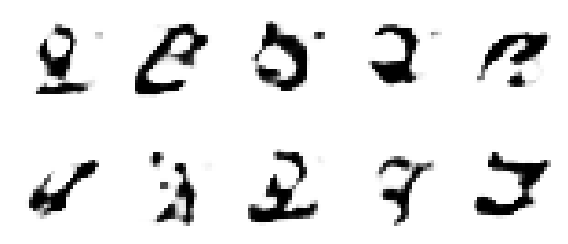

In [ ]:
plot_mnist()
